In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import matplotlib.pyplot as plt


In [57]:
class inv_Tracker():
    """Simula el detector Pixel del CMS en el HL-LHC.
    
        Args:
            
            r_max: distancia en la coordenada radial del último detector
            r_min: distancia en la coordenada radial del primer detector
            r_paso: distancia entre detectores
            h: longitud en el eje Z del Pixel
    """
    def __init__(self,r_min,r_max,h):
        self.r_min=r_min #2.5
        self.r_max=r_max #10
        r_paso=(self.r_max-self.r_min)/3
        self.h=h #60

    def detects(self, trayec, point):
        """Proporciona los puntos de corte de la traza dada con el detector i.
            Cordenadas cilíndricas: (phi, z, detector)
            
            Args:
            
                trayec: Vector director de la traza. (phi,z)
                point: Punto de partida de la traza en la dirección del beam (z)
                
            Returns:
            
                coord: Matriz con los hits en cada detector. Se incluye error en phi y z.(phi,z,detector)
        """
       
        coord = np.zeros( (4, 3) ) # (phi, z, detector)
        for k in range(4):
            error=np.random.normal(0,0.01,2)
            
            coord[k][0]=trayec[0]+error[0]
            coord[k][1]=point+(trayec[1]-point)/self.r_max*(self.r_min+r_paso*k)+error[1]/10
            coord[k][2]=k+1
        return coord

In [59]:
inv_tracker=inv_Tracker(2.5,10,60)
inv_tracker.detects([np.pi,4],2)

array([[3.14083265, 2.50024703, 1.        ],
       [3.14188083, 3.00141148, 2.        ],
       [3.13882951, 3.50029043, 3.        ],
       [3.14864846, 3.99999236, 4.        ]])

In [60]:
class Event():
    
    """ Simula un evento en el Pixel de manera aleatoria.
        
        Args:
            
            num: número de trazas forman el evento
            ruido: valor entre 0 y 1 que determine la cantidad de ruido
            
        
        
    """
    
    
    def __init__(self, num, ruido):
        
        self.num=num
        self.ruido=ruido
        r_min=2.5
        r_max=10.
        r_paso=(r_max-r_min)/3
        h=60.
        global point_rand
        global trayec_rand
        global pos_ruido
        global coord
        point_rand = np.zeros( (self.num, 1) )
        trayec_rand = np.zeros( (self.num, 2) )  
        pos_ruido = np.zeros( (int(self.num*self.ruido),3) )
        coord=np.zeros( (self.num*4,3) )
        for k in range(self.num):

            point_rand[k]=np.random.normal(0,2,1)

            trayec_rand[k][0]=np.random.uniform(0,2*np.pi,1)
            trayec_rand[k][1]=np.random.normal(0,h/4,1)
            coord[int(4*k):int(4*k+4)]=inv_Tracker(r_min,r_max,h).detects(trayec_rand[k],point_rand[k])

        for i in range(int(self.num*self.ruido)):
            
            pos_ruido[i][0]=np.random.uniform(0,2*np.pi,1)
            pos_ruido[i][2]=int(np.random.randint(1,5))
            pos_ruido[i][1]=np.random.uniform(-pos_ruido[i][2]*h/2*1/5,pos_ruido[i][2]*h/2*1/5,1)
       
        
    def show_event(self,abrir,cerrar,azimut,cenital):
        
        """ Muestra en un plot un intervalo del evento, en radianes.

            Args:

                abrir: inicio del intervalo en phi a estudiar
                cerrar: final del intervalo en phi a estudiar

        """
        from mpl_toolkits.mplot3d import Axes3D
        import numpy as np

        import matplotlib.pyplot as plt

        fig1 = plt.figure(figsize = (20,20)) 
        env = fig1.add_subplot(111, projection='3d') 
        # Para que no pierda las proporciones
        env.scatter([-10,-10,10,10],[-10,10,-10,10],[-h/2,-h/2,-h/2,-h/2],color='b')
        env.scatter([-10,-10,10,10],[-10,10,-10,10],[h/2,h/2,h/2,h/2],color='b')

        # DETECTORES

        for i in range(5): # El primero es el beam

            no_values = 20
            phi_cyl = np.linspace(abrir, cerrar, no_values)
            x_walls = (r_min+(i-1)*r_paso)* np.cos(phi_cyl) 
            z_walls = np.linspace(-h/2, h/2, no_values)
            x2D_walls, z2D_walls = np.meshgrid(x_walls, z_walls)
            y2D_walls = np.sqrt((r_min+(i-1)*r_paso)**2 - x2D_walls**2)


            # Detector i
            env.plot_surface(x2D_walls, -y2D_walls, z2D_walls, color='y', alpha=0.1)
            env.plot_surface(x2D_walls, y2D_walls, z2D_walls, color='y', alpha=0.1)
            env.plot_wireframe(x2D_walls, y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.1)
            env.plot_wireframe(x2D_walls, -y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.2)

        # TRAZAS
      

        for k in range(self.num):
            
            x2=np.linspace(0,r_max*np.cos(coord[4*k][0]),30)
            y2=np.linspace(0,r_max*np.sin(coord[4*k][0]),30)
            z2=np.linspace(coord[4*k][1],coord[4*k+3][1],30)

            env.plot(x2,y2,z2,color='m')
        # PUNTOS
        # 1) Hits
        for j in range(4*self.num):
            env.scatter((r_min+(coord[j][2]-1)*r_paso)*np.cos(coord[j][0]),(r_min+(coord[j][2]-1)*r_paso)*np.sin(coord[j][0]),coord[j][1],color='k')
        # 2) Ruido
        for k in range(int(self.num*self.ruido)):
            env.scatter((r_min+(pos_ruido[k][2]-1)*r_paso)*np.cos(pos_ruido[k][0]),(r_min+(pos_ruido[k][2]-1)*r_paso)*np.sin(pos_ruido[k][0]),pos_ruido[k][1],color='r')
        
        # REPRESENTACION

        
        env.view_init(180/np.pi*cenital, 180/np.pi*azimut)


        plt.show()

    def export_event(self):
         
        file=open('/home/pablo/Desktop/TFG/Qiskit/OutputEvent.txt', 'w')
        for i in range(self.num):
            file.write("Traza:"+str(i)+'\n')
            file.write(np.array_str(coord[int(4*i):int(4*i+4)])+'\n')   
            file.write("-"*10+'\n')
        
        file.write(np.array_str(pos_ruido)+'\n')
        file.write("-"*10+'\n')

        file.close()
        return file

In [55]:
event=Event(100,0.4)

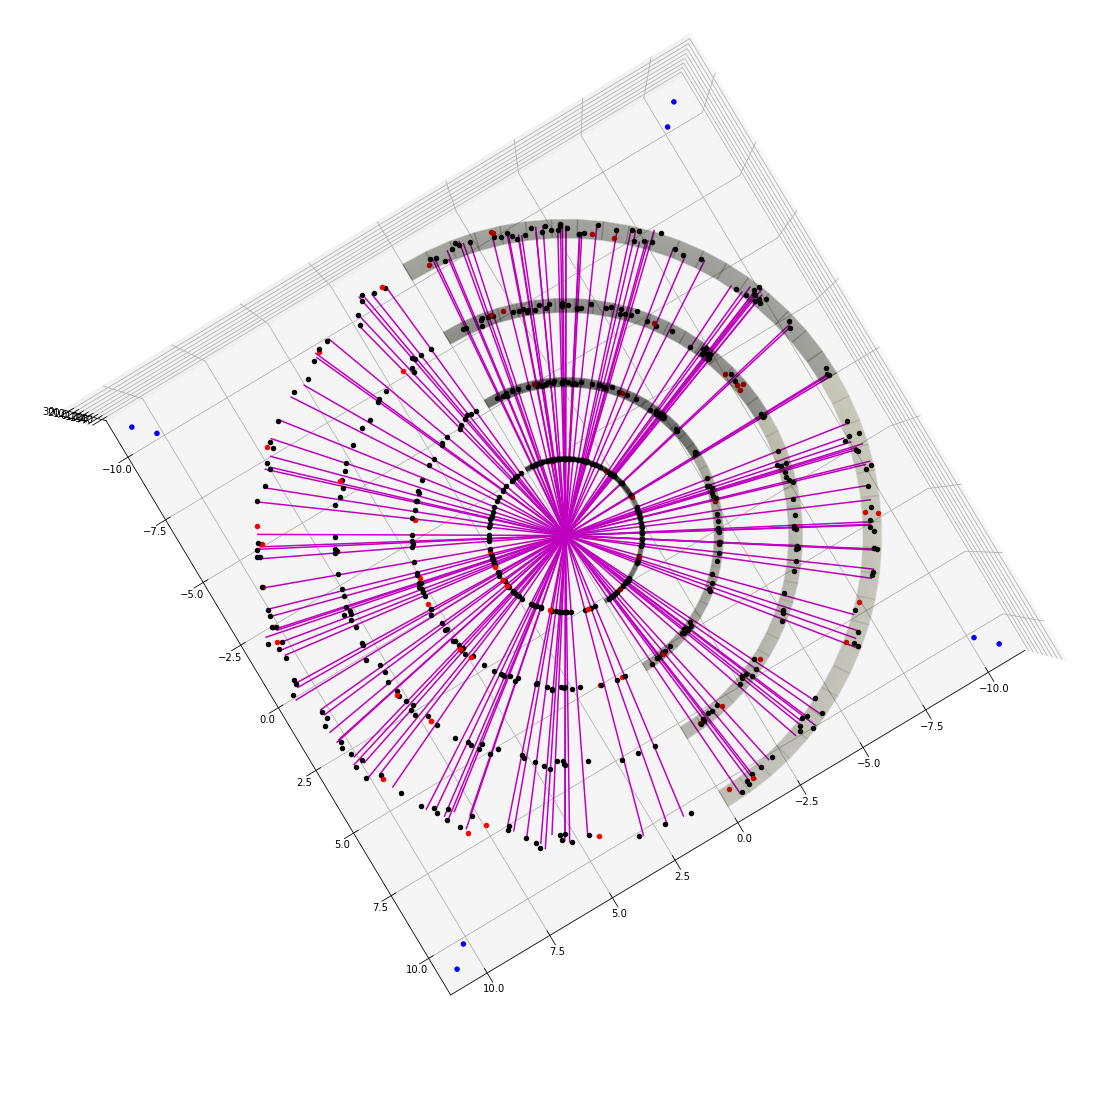

In [49]:
event.show_event(np.pi/2,np.pi,np.pi/3,np.pi/2)

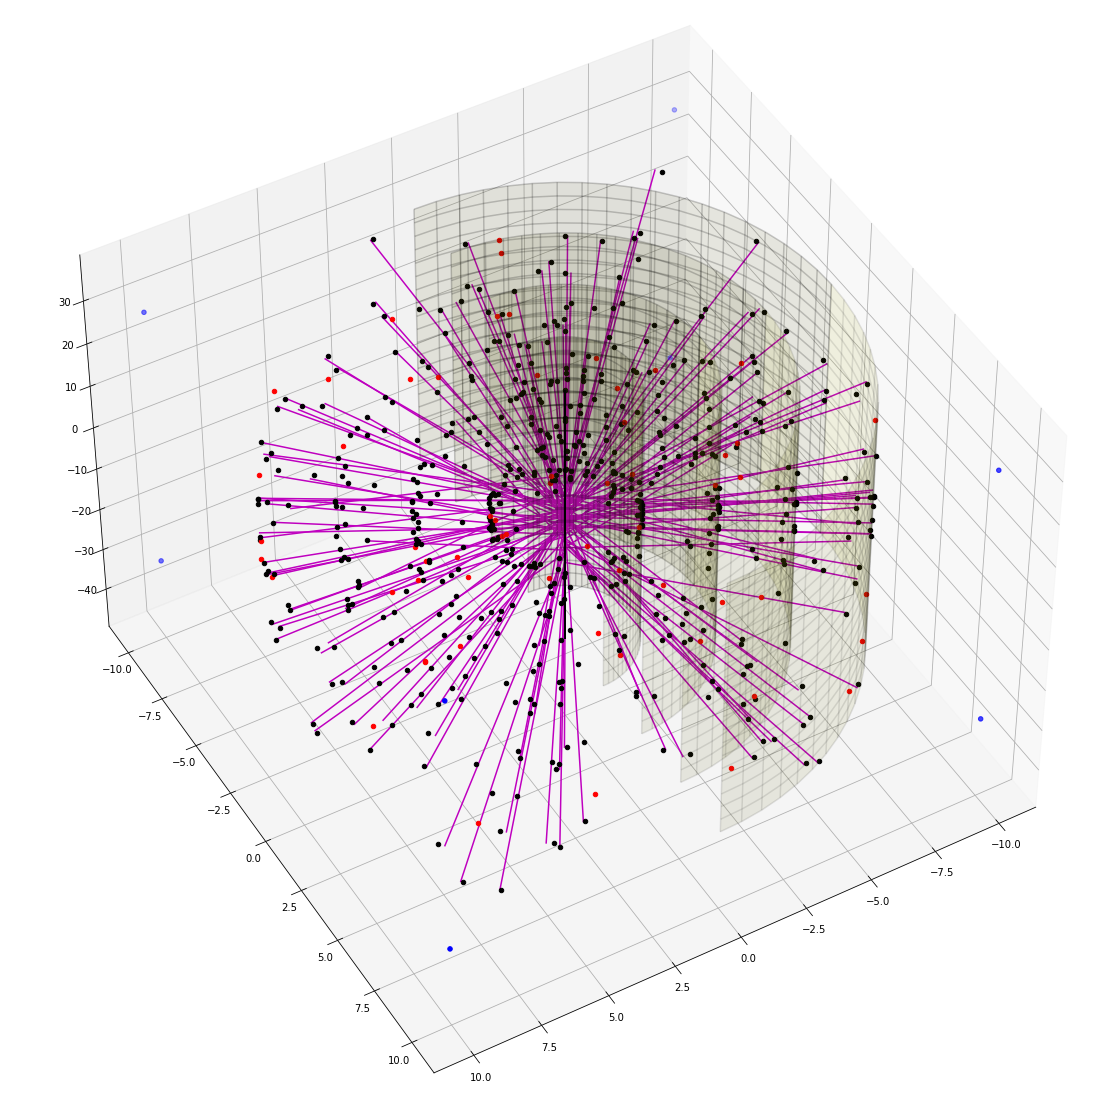

In [50]:
event.show_event(np.pi/2,np.pi,np.pi/3,np.pi/4)

In [56]:
event.export_event()

<_io.TextIOWrapper name='/home/pablo/Desktop/TFG/Qiskit/OutputEvent.txt' mode='w' encoding='UTF-8'>